In [1]:
from yolov5 import detect
from PIL import Image
import os
from glob import glob
import tensorflow as tf

import torch
import os
from glob import glob
import numpy as np
from yolov5.utils.torch_utils import select_device, load_classifier, time_sync
from yolov5.models.experimental import attempt_load


# test input 이미지에서 객체 탐지
- 탐지 결과는 json(dict) 

In [2]:
device = select_device('1')
weights='yolov5/runs/train/exp/weights/best.pt'
model = attempt_load(weights, map_location=device)
modelc = load_classifier(name='resnet50', n=2)  # initialize
#modelc.load_state_dict(torch.load('resnet50.pt', map_location=device)['model']).to(device).eval()

In [3]:
detectedObject_list = detect.object_detection(imgsz=[576],name="query",source="yolov5/hanssem/images/query",device=device, model=model, modelc=modelc)

image 1/1 /workspace/fourElse/KimHeeSu/2021-1-CECD3-four-elSe-1/integrated_main/yolov5/hanssem/images/query/102458.jpg: 576x576 3 closets, Done. (0.007s)
Results saved to yolov5/runs/detect/query5
Done. (0.040s)


In [4]:
detectedObject_list

[{'objectID': '7b56a4d1-de23-4633-8d23-d10922d13994',
  'location': {'xmin': 315, 'ymin': 206, 'xmax': 448, 'ymax': 385},
  'tag': 'closet',
  'objectImagePath': 'yolov5/runs/detect/query5/croppedImages/102458_closet.jpg'},
 {'objectID': '86e589cb-a90a-40c9-8579-f5572d57ab66',
  'location': {'xmin': 0, 'ymin': 52, 'xmax': 348, 'ymax': 515},
  'tag': 'closet',
  'objectImagePath': 'yolov5/runs/detect/query5/croppedImages/102458_closet2.jpg'},
 {'objectID': '4a2ee978-1e3d-4230-8481-c161222fdab4',
  'location': {'xmin': 438, 'ymin': 137, 'xmax': 550, 'ymax': 373},
  'tag': 'closet',
  'objectImagePath': 'yolov5/runs/detect/query5/croppedImages/102458_closet3.jpg'}]

# 모델 로드

In [5]:
from ImageRetrievalClass import ImageRetrievalClass
retrieval = ImageRetrievalClass("IncepResNet", True, False)

retrieval.buildModel(shape_img=(256,256,3))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Loading IncepResNet pre-trained model...
input_shape_model = (256, 256, 3)
output_shape_model = (6, 6, 1536)


# 탐지한 객체 중에서 임의로 하나 선택

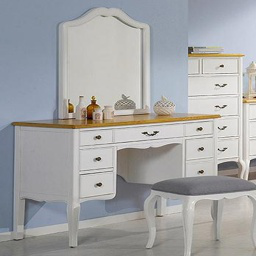

In [6]:
selectObject = detectedObject_list[1]
selectObject_path = selectObject["objectImagePath"]
selectObject_pil = Image.open(selectObject_path)
selectObject_pil

In [7]:
retrieval.readTestSet(selectObject_pil)

Reading train images
test image shape = (256, 256, 3)


In [8]:
X_test = retrieval.testTransform()

Applying image transformer to test images...
 -> X_test.shape = (1, 256, 256, 3)


In [9]:
E_test = retrieval.predictTest(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(retrieval.output_shape_model)))

Inferencing embeddings using pre-trained model...
 -> E_test.shape = (1, 6, 6, 1536)


# 동일 태그를 가진 객체들을 검색대상 pool에서 가져오기
- 추후 mongoDB 쿼리부분으로 바뀌어야 함

In [10]:
jsonFiles_path = glob("./jsonFiles/*.json")


In [11]:
import json
queryed_json_pathList = list()
queryed_jsonList = list()

for path in jsonFiles_path:
    with open(path, "rb") as f:
        jsonFile = json.load(f)

    if jsonFile["tag"] == selectObject["tag"]:
        queryed_json_pathList.append(path)
        queryed_jsonList.append(jsonFile)

In [12]:
queryed_jsonList[0]

{'objectID': 'b3f3e5b3-c378-414c-82cd-6ee1f5150bf2',
 'location': {'xmin': 182, 'ymin': 88, 'xmax': 456, 'ymax': 433},
 'tag': 'closet',
 'objectImagePath': './cropData/train/PngImages/130822_closet_1.png',
 'npyPath': './npyFiles/130822_closet_1.npy',
 'IMG_URL': 'https://image.hanssem.com/hsimg//gds/550/130/130822_A1.jpg'}

# 태그로 쿼리한 json 파일의 npy(E_train)과 E_test를 비교

## json에서 npy가져와서 E_train 만들기

In [13]:
E_train = list()
for json in queryed_jsonList:
    npy = np.load(json["npyPath"])
    E_train.append(npy)


In [14]:
E_train = np.array(E_train)
E_train.shape

(1550, 6, 6, 1536)

In [15]:
retrieval.output_shape_model

(6, 6, 1536)

In [16]:

E_train_flatten = E_train.reshape((-1, np.prod(retrieval.output_shape_model)))
E_test_flatten.shape

(1, 55296)

In [16]:
calculator = retrieval.similarityCalculator(E_train_flatten)

Fitting k-nearest-neighbour model on training images...


## 쿼리 결과의 pool 생성

In [17]:
retrieval_imagePool = [Image.open(json["objectImagePath"]) for json in queryed_jsonList]



## Retrieval

In [18]:
indices = retrieval.retrieval(E_test_flatten=E_test_flatten, calculator=calculator, retrieval_imagePool=retrieval_imagePool )

Performing image retrieval on test images...


In [19]:
print(indices)

[[1496  136 1013  162  275]]


In [20]:
similar_json=[]
similar_json_url=[]
for i in range(5):
    temp=indices[0][i]
    print(temp)
    similar_json.append(queryed_jsonList[temp])
    similar_json_url.append(queryed_jsonList[temp]['IMG_URL'])

1496
1013
305
1469
1411


In [ ]:
print(similar_json)